In [140]:
import pandas as pd
import numpy as np
from statistics import mean
import requests
from bs4 import BeautifulSoup
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvosor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [141]:
main_task = pd.read_csv('main_task.xls')

Смотрим на данные

In [142]:
main_task.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


Для удобства использования pandas напишем все столбцы с маленькой буквы:

In [143]:
main_task.columns = ['restaurant_id', 'city', 'cuisine_style',
                     'ranking', 'rating', 'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta']

## Функции для забора данных с внешних источников

In [144]:
def data_collector(row):
    '''Функция получает строку датафрейма на вход и пытается собрать данные с внешнего источника для 
    таких столбцов как (cuisine_style, price_range, number_of_reviews)'''

    url = 'https://www.tripadvisor.com/' + row[-3]
    global count
    str_index = main_task[main_task['id_ta']
                          == row[-2]].index[0]                                             # Выделяем индекс DF
    print('{} / {} итерация функции  data_collector, {} - индекс'.format(count,
                                                                         null_row, str_index))  # Выводим счётчик итерации функции

    count += 1
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    all_blocks = soup.find_all('a', class_='_2mn01bsa')
    rting_value = soup.find_all('span', class_='_3Wub8auF')

    if pd.isnull(row[2]):
        # Добовляем количество кухонь

        kitchens = [kitchen.text for kitchen in all_blocks[1:]]
        if kitchens != []:
            main_task['cuisine_style'].loc[str_index] = str(kitchens)
        else:
            main_task['cuisine_style'].loc[str_index] = np.nan

    if pd.isnull(row[5]):
        # Добовляем предпологаемый чек

        cost = [bill.text for bill in all_blocks[:1]]
        if (cost != []) and (str(cost[0]) in ['$', '$$ - $$$', '$$$$']):
            main_task['price_range'].loc[str_index] = cost[0]
        else:
            main_task['price_range'].loc[str_index] = np.nan

    if pd.isnull(row[6]):
        # Добовляем количество отзывов

        rating = [rting.text for rting in rting_value[:1]]
        if rating != []:
            rating[0] = rating[0].replace(',', '.')
            main_task['number_of_reviews'].loc[str_index] = float(
                rating[0].split(' ')[0])
        else:
            main_task['number_of_reviews'].loc[str_index] = np.nan


def get_data_coment(row):
    '''Функция получает строку датафрейма на вход и пытается собрать данные с внешнего источника 
    о дате последнего комментария'''

    global count
    url = 'https://www.tripadvisor.com/' + row[-3]
    str_index = main_task[main_task['id_ta']
                          == row[-2]].index[0]                                               # Выделяем индекс
    print('{} - счётчик, {} - индекс, get_data_coment - функция'.format(count, str_index))
    count += 1

    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    all_blocks = soup.find_all('span', class_='ratingDate')
    comm = [all_block.text for all_block in all_blocks[:1]]

    if comm != []:
        main_task['data_comment'].loc[str_index] = str(comm[0])

## Предобрадотка

In [145]:
def cuisine_style1(row):
    '''Функция получает на вход строку с названиями кухонь и
    заполняет словарь, где ключами является название кухни, а 
    значениями их количество встречающиеся DF'''
    if not pd.isnull(row):
        for i in list(row[1:-1].split(',')):
            i = i.strip()
            i = i.replace("'", '')

            if i in kitchen:
                kitchen[i] += 1
            else:
                kitchen.setdefault(i, 1)


def cuisine_style(row):
    '''Функция получает на вход строку с названиями кухонь и
    заполняет список представленным количеством, если кухни в 
    списке отсутствуют то думаем, что предлагается только одна кухня'''
    if pd.isnull(row):
        cuisin.append(1)
    else:
        cuisin.append(len(list(row[1:-1].split(','))))


def data_сonverter(data):
    '''Функция получает на вход строку содержащую дату, когда был оставлен комментарий,
    и вырезает его, записывая в лист и ищем разницу в днях между датами. '''

    # Формируем лист с датами
    data_list = list()
    # Формируем паттерн по дате
    pattern = re.compile('\d+/\d+/\d+')

    for i in pattern.findall(data):
        if len(i) != 0:
            i = datetime.datetime.strptime(i, '%m/%d/%Y')
            data_list.append(i)
            if len(data) != 0:
                # Ищем разницу в днях между датами
                my_tuple.add(max(data_list) - min(data_list))
    return data_list


def func_city_kitchen_rating(row):
    '''Функция получает на вход строку и формирует словарь 
    по городам из самых распространённых кухонь и их рейтингу'''

    # Убираем всё лишнее из строки
    if not pd.isnull(row[1]):
        for i in list(row[1][1:-1].split(',')):
            i = i.strip()
            i = i.replace("'", '')

    # Заполняем словарь и смотрим как кухни распределены по городам
            if row[0] in city_kitchen:
                if i in city_kitchen[row[0]]:
                    city_kitchen[row[0]][i] += 1
                else:
                    city_kitchen[row[0]].setdefault(i, 1)
            else:
                city_kitchen.setdefault(row[0], dict())

    # Заполняем словарь и смотрим как кухни распределены по рейтингу
            if row[0] in rating_kitchen:
                if i in rating_kitchen[row[0]]:
                    rating_kitchen[row[0]][i].append(row[2])
                else:
                    rating_kitchen[row[0]].setdefault(i, [row[2]])
            else:
                rating_kitchen.setdefault(row[0], dict())


def rating_distribution(my_dict):
    '''Выставляем рейтинг по городам '''
    for key, value in my_dict.items():
        for kitchen, value in value.items():
            if (sum(value) / len(value)) == 5 or (sum(value) / len(value)) >= 4.7:
                rating_kitchen[key][kitchen] = 5.0
            elif (sum(value) / len(value)) < 4.7 or (sum(value) / len(value)) >= 4.3:
                rating_kitchen[key][kitchen] = 4.5
            elif (sum(value) / len(value)) < 4.3 or (sum(value) / len(value)) >= 3.7:
                rating_kitchen[key][kitchen] = 4.0
            elif (sum(value) / len(value)) < 3.7 or (sum(value) / len(value)) >= 3.3:
                rating_kitchen[key][kitchen] = 3.5
            elif (sum(value) / len(value)) < 3.3 or (sum(value) / len(value)) >= 2.7:
                rating_kitchen[key][kitchen] = 3.0
            elif (sum(value) / len(value)) < 2.7 or (sum(value) / len(value)) >= 2.3:
                rating_kitchen[key][kitchen] = 2.5
            elif (sum(value) / len(value)) < 2.3 or (sum(value) / len(value)) >= 1.7:
                rating_kitchen[key][kitchen] = 2.0
            elif (sum(value) / len(value)) < 1.7 or (sum(value) / len(value)) >= 1.3:
                rating_kitchen[key][kitchen] = 1.5
            elif (sum(value) / len(value)) < 1.3 or (sum(value) / len(value)) >= 1.0:
                rating_kitchen[key][kitchen] = 1.0


def rating_tester(row):
    '''Функция получает на вход 3 столбца city, rating и cuisine_style.
    После чего на основании данных полученных при сборе словарей rating_kitchen и
    city_kitchen пытаемся предугодать какая кухня была пропущенна в датасете'''
    probability_dict = list()
    count_kitchen = dict()
    city = row[0]
    rating = row[1]
    cuisine_style = row[2]

    # Формируем список из кухонь которые подходят по рейтингу
    if pd.isnull(cuisine_style):
        if city in rating_kitchen:
            for kitchen, value in rating_kitchen[city].items():
                if rating == rating_kitchen[city][kitchen]:
                    probability_dict.append(kitchen)

    # Формируем словарь из кухонь которые находятся в городе с таким же рейтингом
        if len(probability_dict) != 0:
            for kitchen in probability_dict:
                if city in city_kitchen:
                    if kitchen in city_kitchen[city]:
                        count_kitchen.setdefault(
                            kitchen, city_kitchen[city][kitchen])

    # Выбераем наиболее популярную кухню с аналогичным рейтингом
            for kitchen, value in count_kitchen.items():
                if value == max(count_kitchen.values()):
                    if str(kitchen) in rating_kitchen[city]:
                        return [kitchen]
        else:
            for kitchen, value in city_kitchen[city].items():
                if value == min(city_kitchen[city].values()):
                    return [kitchen]

    # В случае если попадается не пустое значение преобразуем его в список
    else:
        kitchen_list = list()
        for kitchen in list(cuisine_style[1:-1].split(',')):
            kitchen = kitchen.strip()
            kitchen = kitchen.replace("'", '')
            kitchen = str(kitchen)
            kitchen_list.append(kitchen)
        return kitchen_list


def test_clean(row):
    '''Заполняем пропуски в столбце number_of_reviews при помощи
    столбца reviews. Наличие комментариев в столбце reviews,
    говорит как минимум об их существовании и в связи с этой логикой
    столбце reviews заполняется значениями 0, 1, 2'''
    number_of_reviews = row[0]
    reviews = row[1]
    reviews = reviews.replace('"', '')
    reviews = reviews.replace('[', '')
    reviews = reviews.replace(']', '')
    reviews = reviews.replace("'", '')
    reviews = reviews.replace('/', '.')
    reviews = reviews.replace(', ', '|')
    reviews = reviews.split('|')[:2]
    if pd.isnull(number_of_reviews):
        if (len(reviews[0]) > 0) and (len(reviews[1]) > 0):
            return 2.0
        elif (len(reviews[0]) > 0) and (len(reviews[1]) == 0):
            return 1.0
        elif (len(reviews[0]) == 0) and (len(reviews[1]) > 0):
            return 1.0
        elif (len(reviews[0]) == 0) and (len(reviews[1]) == 0):
            return 0.0
    else:
        return number_of_reviews


def price_range_count_preparation(row):
    '''Функция получает на вход строку и создаёт словарь 
    со среднем значение рейтинга для каждой кухни и вероятной оплаты'''
    city = row[0]
    price_range = row[1]
    number_of_reviews = row[2]

    if not pd.isnull(price_range):
        if city in price_range_dict:
            if price_range in price_range_dict[city]:
                price_range_dict[city][price_range].append(number_of_reviews)
            else:
                price_range_dict[city].setdefault(
                    price_range, [number_of_reviews])
        else:
            price_range_dict.setdefault(city, dict())


def price_range_dict_def(my_dict):
    '''Функция получает словарь со среднем значение рейтинга
    для каждой кухни и вероятной оплаты'''
    for city, value_my_dict in my_dict.items():
        for price_range, values in value_my_dict.items():
            if city in price_range_dict:
                price_range_dict[city][price_range] = round(
                    sum(values) / len(values))


def price_range_count1(row):
    '''Функция получает на вход столбцы city, price_range, number_of_reviews
    и пытается на основе словаря price_range_dict проставить вероятную оплату
    в пустые значения'''
    city = row[0]
    price_range = row[1]
    number_of_reviews = row[2]

    # Выделяем минимальное,максимальное и среднее значение для каждой кухни
    if pd.isnull(price_range):
        price_range = np.nan
        max_value = max(price_range_dict[city].values())
        min_value = min(price_range_dict[city].values())
        mean_value = sum(price_range_dict[city].values(
        )) - (max(price_range_dict[city].values()) - min(price_range_dict[city].values()))

        # Считаем грацины значений
        upper_limit = round((max_value + mean_value) / 2)
        lower_limit = round((min_value + mean_value) / 2)

        # Фильтруем и подставляем значения
        if number_of_reviews > upper_limit:
            for my_price_range, my_number_of_reviews in price_range_dict[city].items():
                if my_number_of_reviews == max_value:
                    return my_price_range
        elif (number_of_reviews <= upper_limit) and (number_of_reviews > lower_limit):
            for my_price_range, my_number_of_reviews in price_range_dict[city].items():
                if my_number_of_reviews == mean_value:
                    return my_price_range
        elif number_of_reviews <= lower_limit:
            for my_price_range, my_number_of_reviews in price_range_dict[city].items():
                if my_number_of_reviews == min_value:
                    return my_price_range
    else:
        return price_range


def find_item(cell):
    '''Функция для создания дополнительных столбцов в
    датафрейме из листа в столбце cuisine_style'''
    if item in cell:
        return 1
    return 0


def price_range_number(price_range):
    '''Функция получает значение price_range и меняет его на цифры'''
    if price_range == '$':
        return 1
    elif price_range == '$$ - $$$':
        return 2
    elif price_range == '$$$$':
        return 2
    
    
def func_ranking_popularity(ranking):
    '''Функция получает на вход ranking и на основе 
    этих данных заполняет новый столбец по популярности
    где значение 1 - наименьшее, а 7 - наибольгее'''
    if ranking < 2500:
        return 1.0
    elif 2500 <= ranking < 5000:
        return 2.0
    elif 5000 <= ranking < 7500:
        return 3.0
    elif 7500 <= ranking < 10000:
        return 4.0
    elif 10000 <= ranking < 12500:
        return 5.0
    elif 12500 <= ranking < 15000:
        return 6.0
    elif 15000 < ranking:
        return 7.0

Какие столбцы НЕ содержат пропущенных (None) значений?

In [146]:
main_task.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


В каких столбцах данные хранятся в числовом формате?

In [147]:
for col in list(main_task.describe(include=['float64']).columns):
    print(col)

ranking
rating
number_of_reviews


## Машинное обучение для чайников

Сколько вариантов непустых значений встречается в столбце Price Range?

In [148]:
main_task['price_range'].nunique()

3

Как в датафрейме обозначается самый низкий уровень цен?

In [149]:
main_task['price_range'].unique()[-1]

'$'

Сколько ресторанов относятся к среднему ценовому сегменту?

In [150]:
len(main_task[main_task['price_range'] == '$$ - $$$'])

18412

Сколько городов представлено в наборе данных?

In [151]:
main_task['city'].nunique()

31

Сколько типов кухонь представлено в наборе данных?

In [152]:
kitchen = dict()
main_task['cuisine_style'].apply(lambda row: cuisine_style1(row))
len(kitchen)

125

Какая кухня представлена в наибольшем количестве ресторанов? Введите название кухни без кавычек или апострофов.

In [153]:
for key, value in kitchen.items():
    if value == max(kitchen.values()):
        print(key)

Vegetarian Friendly


Какое среднее количество кухонь предлагается в одном ресторане? Если в данных отсутствует информация о типах кухонь, то считайте, что в этом ресторане предлагается только один тип кухни. Ответ округлите до одного знака после запятой.

In [154]:
cuisin = list()
main_task['cuisine_style'].apply(lambda x: cuisine_style(x))
round(mean(cuisin), 1)

2.6

Проверка на наличее дубликатов

In [155]:
print('{} количество уникальных url адресов'.format(
    main_task['url_ta'].nunique()))
print('Количество уникальных url адресов и идентификатор ресторана совпадают - {}'.format(
    main_task['url_ta'].nunique() == main_task['id_ta'].nunique()))
print('Количество дублей в DF - {}'.format(len(main_task) -
                                           main_task['url_ta'].nunique()))

39980 количество уникальных url адресов
Количество уникальных url адресов и идентификатор ресторана совпадают - True
Количество дублей в DF - 20


## Вывод: 
Поскольку количество уникальных url адресов в DF составляет 39980 из 40000, то просто удалим дубликаты из DF. Поскольку они не влияют на общую картину


Удаляем дубликаты строк

In [156]:
main_task = main_task.drop_duplicates(subset=['url_ta'], keep='first')
main_task.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      39980 non-null  object 
 1   city               39980 non-null  object 
 2   cuisine_style      30701 non-null  object 
 3   ranking            39980 non-null  float64
 4   rating             39980 non-null  float64
 5   price_range        26101 non-null  object 
 6   number_of_reviews  37437 non-null  float64
 7   reviews            39980 non-null  object 
 8   url_ta             39980 non-null  object 
 9   id_ta              39980 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.4+ MB


Добавляем столбец, где будем хранить данные о времени последнего комментария

In [157]:
main_task['data_comment'] = np.nan
main_task.head(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,data_comment
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,NaN
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,NaN
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,NaN
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,NaN
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,NaN


Посчитаем коичество строк в которых есть пропущенные значения в столбцах cuisine_style, price_range, number_of_reviews

In [158]:
null_row = len(main_task[(main_task['cuisine_style'].isnull()) | (
               main_task['price_range'].isnull()) | (main_task['number_of_reviews'].isnull())])
null_row

14299

In [ ]:
count = 1
main_task[(main_task['cuisine_style'].isnull()) | (
    main_task['price_range'].isnull()) | (main_task['number_of_reviews'].isnull())].apply(lambda row: data_collector(row), axis=1)

In [ ]:
count = 1
main_task.apply(lambda row: get_data_coment(row), axis=1)

In [159]:
main_task.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      39980 non-null  object 
 1   city               39980 non-null  object 
 2   cuisine_style      30701 non-null  object 
 3   ranking            39980 non-null  float64
 4   rating             39980 non-null  float64
 5   price_range        26101 non-null  object 
 6   number_of_reviews  37437 non-null  float64
 7   reviews            39980 non-null  object 
 8   url_ta             39980 non-null  object 
 9   id_ta              39980 non-null  object 
 10  data_comment       0 non-null      float64
dtypes: float64(4), object(7)
memory usage: 3.7+ MB


In [ ]:
main_task.to_csv('main_task_new_comment')

In [160]:
main_task_new = pd.read_csv('main_task_new_comment')
main_task_new.head()

,Unnamed: 0,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,data_comment
0,0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"Reviewed February 14, 2020"
1,1,id_1535,Stockholm,"['Asian', 'Nepali']",1537.0,4.0,$$ - $$$,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"Reviewed February 27, 2020"
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,Reviewed 1 week ago
3,3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,"Reviewed February 19, 2016"
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"Reviewed September 10, 2020"


Вопросы об отзывах

In [161]:
main_task_new = main_task_new.dropna(subset=['data_comment'], axis=0)

Какое максимальное количество дней отделяет даты публикации отзывов, размещённых на сайте ресторана? Введите количество дней в виде целого числа.

In [162]:
my_tuple = set()
main_task_new['new_data_comment'] = main_task_new['reviews'].apply(
    lambda data: data_сonverter(data))

In [163]:
main_task_new['new_data_comment'].max()

[datetime.datetime(2018, 2, 26, 0, 0), datetime.datetime(2018, 2, 26, 0, 0)]

Какое максимальное количество дней отделяет даты публикации отзывов, размещённых на сайте ресторана? Введите количество дней в виде целого числа.

In [164]:
max(my_tuple)

datetime.timedelta(days=3207)

In [165]:
main_task_new = pd.read_csv('main_task_new_comment')
main_task_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39980 entries, 0 to 39979
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         39980 non-null  int64  
 1   restaurant_id      39980 non-null  object 
 2   city               39980 non-null  object 
 3   cuisine_style      34784 non-null  object 
 4   ranking            39980 non-null  float64
 5   rating             39980 non-null  float64
 6   price_range        32541 non-null  object 
 7   number_of_reviews  39646 non-null  float64
 8   reviews            39980 non-null  object 
 9   url_ta             39980 non-null  object 
 10  id_ta              39980 non-null  object 
 11  data_comment       36177 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 3.7+ MB


## Попытка заполений недостающих значений

In [166]:
main_task_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39980 entries, 0 to 39979
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         39980 non-null  int64  
 1   restaurant_id      39980 non-null  object 
 2   city               39980 non-null  object 
 3   cuisine_style      34784 non-null  object 
 4   ranking            39980 non-null  float64
 5   rating             39980 non-null  float64
 6   price_range        32541 non-null  object 
 7   number_of_reviews  39646 non-null  float64
 8   reviews            39980 non-null  object 
 9   url_ta             39980 non-null  object 
 10  id_ta              39980 non-null  object 
 11  data_comment       36177 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 3.7+ MB


Посмотрим распределение признака

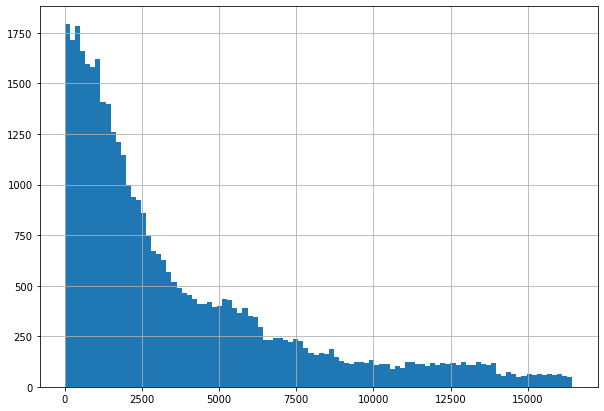

In [167]:
plt.rcParams['figure.figsize'] = (10,7)
main_task_new['ranking'].hist(bins=100)

На основе полученных данных создаём новый категориальный признак

In [168]:
main_task_new['ranking_popularity'] = main_task_new['ranking'].apply(lambda ranking: func_ranking_popularity(ranking))

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

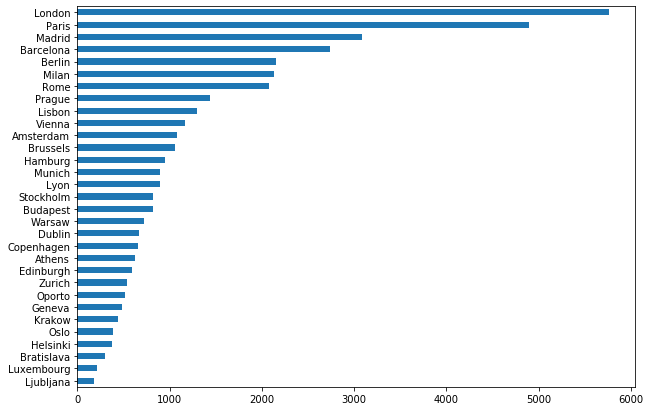

In [169]:
main_task_new['city'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе

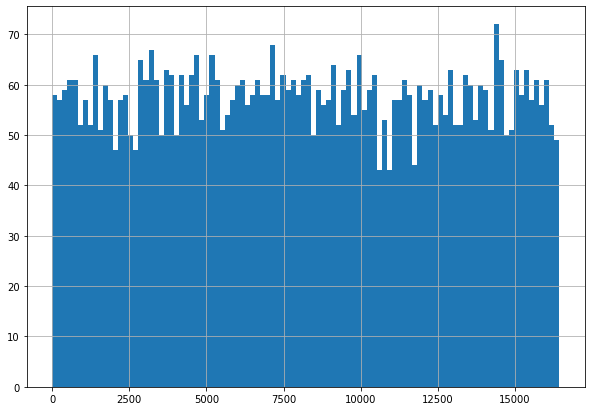

In [170]:
main_task_new['ranking'][main_task_new['city'] =='London'].hist(bins=100)

Посмотрим на топ 10 городов

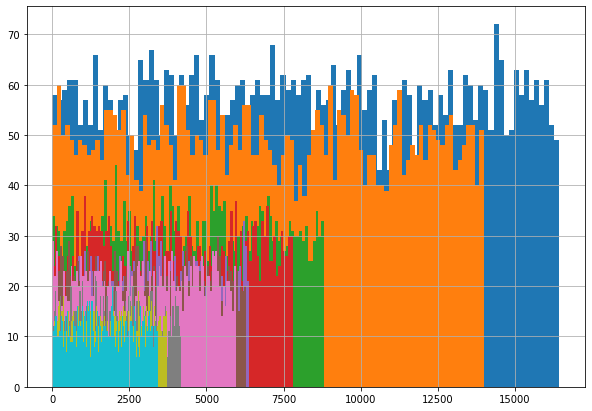

In [171]:
for x in (main_task_new['city'].value_counts())[0:10].index:
    main_task_new['ranking'][main_task_new['city'] == x].hist(bins=100)
plt.show()

Посмотрим распределение целевой переменной

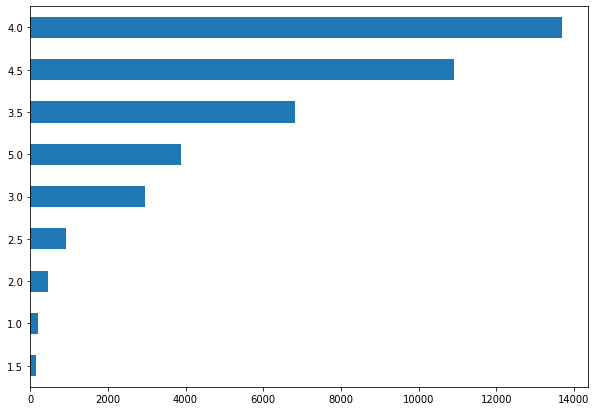

In [172]:
main_task_new['rating'].value_counts(ascending=True).plot(kind='barh')

Посмотрим распределение целевой переменной относительно признака

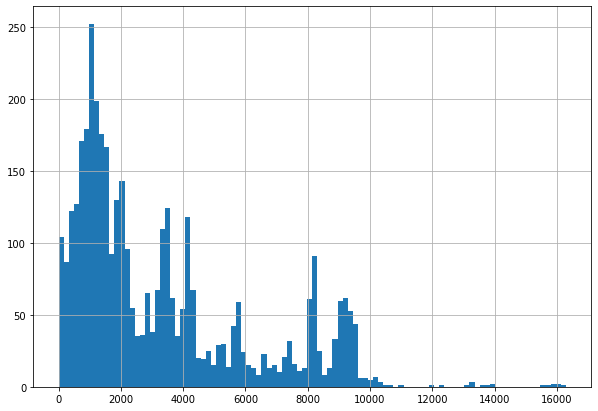

In [173]:
main_task_new['ranking'][main_task_new['rating'] == 5].hist(bins=100)

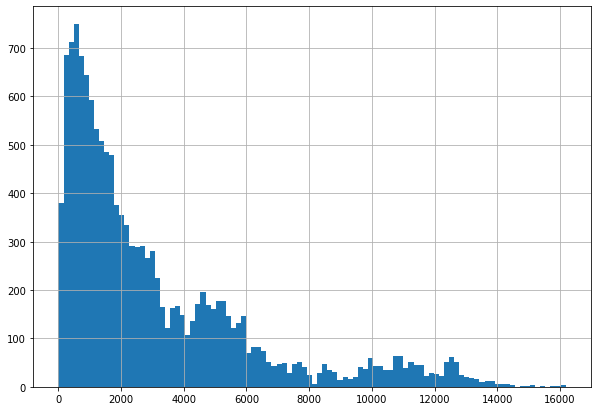

In [174]:
main_task_new['ranking'][main_task_new['rating'] == 4].hist(bins=100)

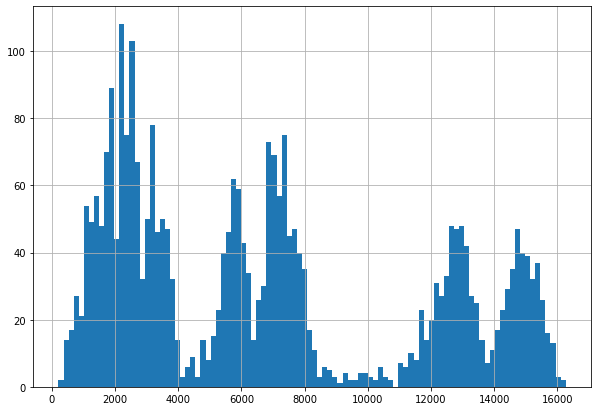

In [175]:
main_task_new['ranking'][main_task_new['rating'] == 3].hist(bins=100)

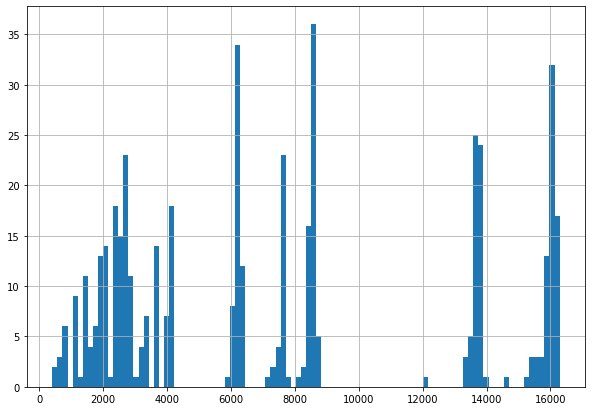

In [176]:
main_task_new['ranking'][main_task_new['rating'] == 2].hist(bins=100)

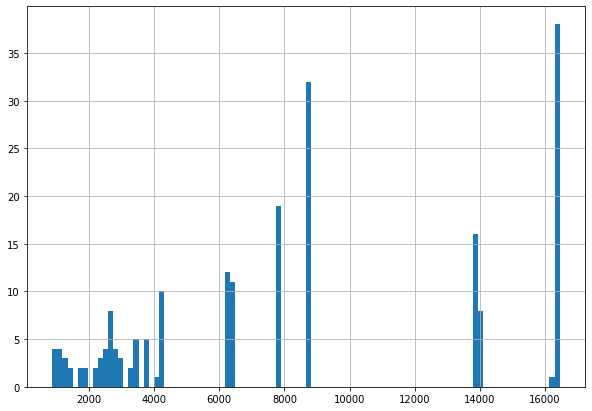

In [177]:
main_task_new['ranking'][main_task_new['rating'] == 1].hist(bins=100)

## Вывод

Наибольшее количество ресторанов находится в крупных западноевропейских городах, что не удивительно ведь данные города находятся в страна с развитой экономикой. Также удивило, что наиболее выставляемый рейтинг ресторанов составляет 4, но при этом ресторанов с рангом мнение 2500 в своём городе подавляющее большинство. Из чего моно сделать вывод, что часть рейтингов просто "накручена".

In [178]:
# Создаём словарь с респределением кухонь по городам
city_kitchen = dict()

# Создаём словарь с среднем рейтингом кухни в городе
rating_kitchen = dict()

main_task_new[['city', 'cuisine_style', 'rating']].apply(
    lambda row: func_city_kitchen_rating(row), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
39975    None
39976    None
39977    None
39978    None
39979    None
Length: 39980, dtype: object

In [179]:
# Приводим рейтинг в общий вид
rating_distribution(rating_kitchen)

In [180]:
main_task_new.head()

,Unnamed: 0,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,data_comment,ranking_popularity
0,0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"Reviewed February 14, 2020",3.0
1,1,id_1535,Stockholm,"['Asian', 'Nepali']",1537.0,4.0,$$ - $$$,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"Reviewed February 27, 2020",1.0
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,Reviewed 1 week ago,1.0
3,3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,"Reviewed February 19, 2016",2.0
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"Reviewed September 10, 2020",1.0


In [181]:
main_task_new['cuisine_style'] = main_task_new[['city', 'rating',
                                                'cuisine_style']].apply(lambda row: rating_tester(row), axis=1)

In [182]:
# Видим, что в столбце cuisine_style пропусков нет.
main_task_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39980 entries, 0 to 39979
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          39980 non-null  int64  
 1   restaurant_id       39980 non-null  object 
 2   city                39980 non-null  object 
 3   cuisine_style       39980 non-null  object 
 4   ranking             39980 non-null  float64
 5   rating              39980 non-null  float64
 6   price_range         32541 non-null  object 
 7   number_of_reviews   39646 non-null  float64
 8   reviews             39980 non-null  object 
 9   url_ta              39980 non-null  object 
 10  id_ta               39980 non-null  object 
 11  data_comment        36177 non-null  object 
 12  ranking_popularity  39980 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 4.0+ MB


Видим, что где в столбце number_of_reviews есть пропуски, полностью заполнен столбец reviews в котором содержится информация как минимум о наличии одного комментария у ресторана. Будем действовать логикой, что если у ресторана нет комментариев в столбце reviews то в столбце number_of_reviews ставим 0, если есть хотя бы один комментарий ставим 1, если оба то 2. 

In [183]:
main_task_new['number_of_reviews'] = main_task_new[[
    'number_of_reviews', 'reviews']].apply(lambda row: test_clean(row), axis=1)

In [184]:
main_task_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39980 entries, 0 to 39979
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          39980 non-null  int64  
 1   restaurant_id       39980 non-null  object 
 2   city                39980 non-null  object 
 3   cuisine_style       39980 non-null  object 
 4   ranking             39980 non-null  float64
 5   rating              39980 non-null  float64
 6   price_range         32541 non-null  object 
 7   number_of_reviews   39980 non-null  float64
 8   reviews             39980 non-null  object 
 9   url_ta              39980 non-null  object 
 10  id_ta               39980 non-null  object 
 11  data_comment        36177 non-null  object 
 12  ranking_popularity  39980 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 4.0+ MB


In [185]:
main_task_new.head()

,Unnamed: 0,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,data_comment,ranking_popularity
0,0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"Reviewed February 14, 2020",3.0
1,1,id_1535,Stockholm,"[Asian, Nepali]",1537.0,4.0,$$ - $$$,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"Reviewed February 27, 2020",1.0
2,2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,Reviewed 1 week ago,1.0
3,3,id_3456,Berlin,[Moroccan],3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,"Reviewed February 19, 2016",2.0
4,4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"Reviewed September 10, 2020",1.0


СОздаём словарь со средним рейтингом для каждой кухни и верояного чека

In [186]:
price_range_dict = dict()
main_task_new[['city', 'price_range', 'number_of_reviews']].apply(
    lambda row: price_range_count_preparation(row), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
39975    None
39976    None
39977    None
39978    None
39979    None
Length: 39980, dtype: object

Приводим словарь в нужный вид

In [187]:
price_range_dict_def(price_range_dict)

Подсавляем значения

In [188]:
main_task_new['price_range'].fillna(value=np.nan, inplace=True)
main_task_new['price_range'] = main_task_new[['city', 'price_range',
                                              'number_of_reviews']].apply(lambda row: price_range_count1(row), axis=1)

In [189]:
main_task_new = main_task_new.dropna(subset=['price_range'], axis=0)
main_task_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39978 entries, 0 to 39979
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          39978 non-null  int64  
 1   restaurant_id       39978 non-null  object 
 2   city                39978 non-null  object 
 3   cuisine_style       39978 non-null  object 
 4   ranking             39978 non-null  float64
 5   rating              39978 non-null  float64
 6   price_range         39978 non-null  object 
 7   number_of_reviews   39978 non-null  float64
 8   reviews             39978 non-null  object 
 9   url_ta              39978 non-null  object 
 10  id_ta               39978 non-null  object 
 11  data_comment        36177 non-null  object 
 12  ranking_popularity  39978 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 4.3+ MB


In [190]:
main_task_new

,Unnamed: 0,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,data_comment,ranking_popularity
0,0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"Reviewed February 14, 2020",3.0
1,1,id_1535,Stockholm,"[Asian, Nepali]",1537.0,4.0,$$ - $$$,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"Reviewed February 27, 2020",1.0
2,2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,Reviewed 1 week ago,1.0
3,3,id_3456,Berlin,[Moroccan],3458.0,5.0,$,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,"Reviewed February 19, 2016",2.0
4,4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"Reviewed September 10, 2020",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39975,39995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,Reviewed 1 week ago,1.0
39976,39996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,"Reviewed April 7, 2020",3.0
39977,39997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,4.5,$,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,"Reviewed November 3, 2016",1.0
39978,39998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,"Reviewed June 11, 2019",1.0


## Создаем доп столбцы на основе концепции dummy variables

Создаём множество из уникальных кухонь

In [191]:
kitchen_set = set()
for kitchens in main_task_new['cuisine_style']:
    for kitchen in kitchens:
        kitchen_set.add(kitchen)

Создаём категориальные признаки по концепции dummy variables

In [192]:
for item in kitchen_set:
    main_task_new[item] = main_task_new['cuisine_style'].apply(find_item)
main_task_new['cuisine_style'] = main_task_new['cuisine_style'].apply(
    lambda x: len(x))

In [193]:
main_task_new['price_range'] = main_task_new['price_range'].apply(
    lambda price_range: price_range_number(price_range))

In [194]:
main_task_new = pd.get_dummies(main_task_new, columns=[
                               'city', ], dummy_na=True)

In [195]:
object_columns = [
    s for s in main_task_new.columns if main_task_new[s].dtypes == 'object']
main_task_new.drop(object_columns, axis=1, inplace=True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [196]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = main_task_new.drop(['rating'], axis=1)
y = main_task_new['rating']

In [197]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [198]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [199]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [200]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

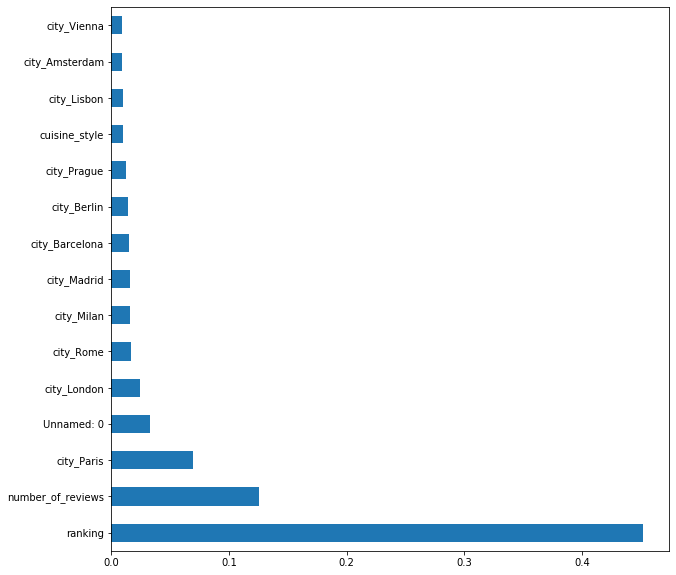

In [201]:

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [202]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2163881940970485


In [203]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39978 entries, 0 to 39979
Columns: 186 entries, Unnamed: 0 to city_nan
dtypes: float64(3), int64(151), uint8(32)
memory usage: 48.5 MB


## Главный вывод

После всех проделанных операций и возможности уменьшить МАЕ более чем в 2 раза по сравнению с первоначальным значением, можно сделать вывод, что концепция и решения, разработанные к данному конкретному кейсу вполне жизнеспособны. Благодаря подключению внешних источников информации и обработки большей части пропусков с преминением концепции dummy variables удалось добиться вполне приемлемого результата.